In [1]:
!pip install transformers
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
with open("/content/drive/MyDrive/yearly-bias/ALL.txt", "r") as f:
    all_numbers = []
    for line in f:
        all_numbers.append(int(line.split('-')[1].split('.')[0]))

print(len(all_numbers))

62


In [3]:
from tqdm import tqdm
from transformers import pipeline
from transformers import AutoModel, RobertaTokenizerFast
import numpy as np
import torch
from tqdm import tqdm
from transformers import pipeline
from itertools import product, permutations, chain
import matplotlib.pyplot as plt
import scipy
import torch
import pickle
from datasets import load_dataset
import nltk
import random
import torch.nn as nn
import sys

In [4]:
# this is the only available pre-training dataset of roberta
# other datasets are not available with the streaming option
# https://huggingface.co/docs/datasets/stream
dataset = load_dataset("stas/openwebtext-10k")

Reusing dataset openwebtext-10k (/root/.cache/huggingface/datasets/stas___openwebtext-10k/plain_text/1.0.0/3a8df094c671b4cb63ed0b41f40fb3bd855e9ce2e3765e5df50abcdfb5ec144b)


  0%|          | 0/1 [00:00<?, ?it/s]

In [5]:
# get all sentences
nltk.download('punkt')

sents = []
for d in tqdm(dataset['train']):
  sents += nltk.sent_tokenize(d['text'])

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
100%|██████████| 10000/10000 [00:20<00:00, 496.24it/s]


In [6]:
# get the device
device = "cuda:0" if torch.cuda.is_available() else "cpu"

In [7]:
# define cosine similarity
cos = nn.CosineSimilarity(dim=0, eps=1e-6)

In [8]:
# test only a few checkpoints

numbers = [100000, 200000, 300000, 400000, 500000,
           600000, 700000, 800000, 900000, 1000000]
intras = []
inters = []

for number in numbers:
    # do not use the masked version of AutoModel
    model = AutoModel.from_pretrained(f"/content/drive/MyDrive/yearly-bias/models/checkpoint-{number}").to(device)
    tokenizer = RobertaTokenizerFast.from_pretrained(f"/content/drive/MyDrive/yearly-bias/models/checkpoint-{number}")

    # save embeddings of all sentences
    all_embeddings = []

    # 200 is faster than 500
    chunk_size = 200
    num_used = chunk_size * 10

    # use only part of the sentences as a very rough estimate
    # results do not seem to qualitatively differ
    for i in tqdm(range(0, num_used, chunk_size)):
        chunk = sents[i: i + chunk_size]
        encoded_input = tokenizer(chunk, padding=True, return_tensors='pt').to(device)
        lens = torch.sum(encoded_input.attention_mask, dim = 1)
        with torch.no_grad():
            model_output = model(**encoded_input)

        for i, emb in enumerate(model_output.last_hidden_state):
            # get hidden state by available length
            all_embeddings.append(list(emb)[:lens[i]])

    intra = []
    inter = []

    for ii, embeddings in tqdm(enumerate(all_embeddings)):
        # avoid same sentence
        exclude_sent = all_embeddings[:ii] + all_embeddings[ii+1:]
        for jj, embedding in enumerate(embeddings):
          # avoid same word
          exclude_word = embeddings[:jj] + embeddings[jj+1:]

          h_i = embedding
          h_j = random.choice(exclude_word)
          h_k = random.choice(random.choice(exclude_sent))

          intra.append(cos(h_i, h_j).item())
          inter.append(cos(h_i, h_k).item())

    intras.append(sum(intra)/len(intra))
    inters.append(sum(inter)/len(inter))

Some weights of the model checkpoint at /content/drive/MyDrive/yearly-bias/models/checkpoint-100000 were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.dense.weight', 'lm_head.decoder.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████| 10/10 [00:11<00:00,  1.12s/it]
2000it [00:13, 151.08it/s]
Some weights of the model checkpoint at /content/drive/MyDrive/yearly-bias/models/checkpoint-200000 were not used when initializing RobertaModel: ['lm_

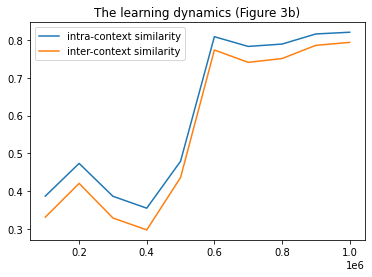

In [9]:
plt.plot(numbers, intras, label="intra-context similarity")
plt.plot(numbers, inters, label="inter-context similarity")
plt.title("The learning dynamics (Figure 3b)")
plt.legend()
plt.show()